In [3]:
import sys
sys.path.append('../')

from util.benchmarking import *

from quantum.hamiltonians import heisenberg,long_range_tfim,transverse_ising,cluster,Madjumdar_Gosh,long_range_XY_model
from quantum.util import flatten_mpo,flatten_mps,measure_magnetizations
from quantum.basis_enrichment import expand, MPS_krylov
from quantum.dmrg import dmrg2
from quantum.tdvp import tdvp_implicit

from tensornetwork.contraction import random_contraction_inc
from tensornetwork.stopping import Cutoff,FixedDimension
from tensornetwork.linalg import truncated_svd
from tensornetwork.MPO import MPO
from tensornetwork.MPS import MPS

import time
import pandas as pd
import numpy as np 
import scipy 
from tqdm import tqdm 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

### Figure 3: Light cone TDVP experiment with ancillary Krylov subspace expansion
This notebook generates the main experimental figure in section 5 

In [55]:
def plot_runtime_vs_N(krylov_methods, N_list, results_df):
    fig, ax = plt.subplots()
    palette = sns.color_palette("Set1", 6)
    plot_styles = {
        'naive': (palette[0], 'o', 'Contract-Then-Compress', '--'),   # First color, circle marker, dashed line
        'random': (palette[1], 's', 'Randomized Contraction', '-'),  # Second color, square marker, solid line
        'zipup': (palette[2], 'D', 'Zip-up Contraction', '-'),       # Third color, diamond marker, solid line
        'density': (palette[3], '^', 'Density Matrix Contraction', '-'), # Fourth color, triangle up marker, solid line
        'fit': (palette[4], 'v', 'Fitting Contraction', '-'),        # Fifth color, triangle down marker, solid line
        'rand_then_orth': ('g', '^', 'Rand_then_orth Contraction', '--'),      
        'Nyst': ('b', 'v', 'Nystrom Contraction', '--'),
    }

    for method in krylov_methods:
        if method in plot_styles:
            color, marker, label, linestyle = plot_styles[method]
            method_data = results_df[results_df['Krylov Method'] == method]
            ax.plot(method_data['System Size (N)'], method_data['Runtime (s)'], 
                    color=color, marker=marker, label=label, markersize=6, linewidth=1.5, linestyle=linestyle)
    
    ax.set_title("Runtime vs System Size (N)")
    ax.set_xlabel("System Size (N)")
    ax.set_ylabel("Runtime (s)")
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

    return ax

def plot_bond_dim_dynamics(krylov_methods, bond_dim_tracking,N_list):
    plt.figure(figsize=(10, 6))
    
    for krylov_method in krylov_methods:
        plt.plot(bond_dim_tracking[krylov_method], label=f"{krylov_method} Method")
    
    plt.xlabel("Time Step")
    plt.ylabel("Max Bond Dimension")
    plt.title(f"Max Bond Dimension Growth Over Time for N={N_list[-1]}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_magnetization_and_diff(mags_modified, mags_diff, midpoint, times):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot magnetization at the midpoint
    axs[0].plot(times, mags_modified[midpoint], label='Modified State', linestyle='-')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Magnetization at Midpoint')
    axs[0].legend()
    
    # Contour plot of differences
    cmap = plt.get_cmap('plasma')
    levels = np.linspace(0, np.abs(mags_diff).max(), 300)  
    contour = axs[1].contourf(np.abs(mags_diff.T), levels=levels, cmap=cmap, vmin=0) 
    cbar = fig.colorbar(contour, ax=axs[1])
    cbar.set_label('Magnitude')
    axs[1].set_title('Contour Plot of Differences')
    axs[1].set_xlabel('Particle Index')
    axs[1].set_ylabel('Timestep')

    plt.tight_layout()
    plt.show()
    
    return fig, axs

def plot_results(results, N, dt, steps, contraction_types):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # Adjusted for 5 columns
    palette = sns.color_palette("Set1", 6)
    colors = {
        'naive': palette[0],   # First color from the palette
        'random': palette[1],  # Second color from the palette
        'zipup': palette[2],   # Third color from the palette
        'density': palette[3], # Fourth color from the palette
        'fit': palette[4],     # Fifth color from the palette
        'baseline': palette[5], 
        'rand_then_orth': 'g', # Green for 'rand_then_orth'
        'nyst': 'b',           # Blue for 'nyst'
    }
    # First Row: Magnetization Differences Contour Plots
    for i, ct in enumerate(contraction_types + ['baseline']):
        ax = axs[0, i]
        levels = np.linspace(0, np.abs(results['mags_diff'][ct]).max(), 300)
        contour = ax.contourf(np.abs(results['mags_diff'][ct].T), levels=levels, cmap='plasma', vmin=0)
        cbar = fig.colorbar(contour, ax=ax)
        cbar.set_label('Magnitude')
        ax.set_title(f'Diff {ct.capitalize()}')
        ax.set_xlabel('Particle Index')
        ax.set_ylabel('Timestep')
    
    # Second Row
    # Magnetization at Midpoint
    for idx, ct in enumerate(contraction_types + ['baseline']):
        axs[1, 0].plot(np.linspace(0, dt * steps, steps + 1), results['mags_modified'][ct][N // 2], 
                       label=ct.capitalize(), color=colors[ct], linestyle='--', linewidth=7-idx)
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Magnetization at Midpoint')
    axs[1, 0].legend()
    axs[1, 0].set_title('Magnetization at Midpoint')

    # Bond Dimension Over Time
    for ct in contraction_types + ['baseline']:
        axs[1, 1].plot(results['bond_dim'][ct], label=ct.capitalize(), color=colors[ct])
    axs[1, 1].set_xlabel('Timestep')
    axs[1, 1].set_ylabel('Bond Dimension')
    axs[1, 1].legend()
    axs[1, 1].set_title('Bond Dimension Over Time')

    # MPS Krylov Runtimes
    for ct in contraction_types:
        axs[1, 2].plot(results['krylov_times'][ct], label=f'Krylov {ct.capitalize()}', color=colors[ct])
    axs[1, 2].set_xlabel('Timestep')
    axs[1, 2].set_ylabel('Time (s)')
    axs[1, 2].set_yscale('log')
    axs[1, 2].legend()
    axs[1, 2].set_title('MPS Krylov Runtime')

    # Expand Runtimes
    for ct in contraction_types:
        axs[1, 3].plot(results['expand_times'][ct], label=f'Expand {ct.capitalize()}', color=colors[ct])
    axs[1, 3].set_xlabel('Timestep')
    axs[1, 3].set_ylabel('Time (s)')
    axs[1, 3].set_yscale('log')
    axs[1, 3].legend()
    axs[1, 3].set_title('Expand Runtime')

    # TDVP Runtimes
    for ct in contraction_types + ['baseline']:
        axs[1, 4].plot(results['tdvp_times'][ct], label=f'TDVP {ct.capitalize()}', color=colors[ct])
    axs[1, 4].set_xlabel('Timestep')
    axs[1, 4].set_ylabel('Time (s)')
    axs[1, 4].set_yscale('log')
    axs[1, 4].legend()
    axs[1, 4].set_title('TDVP Runtime')

    plt.tight_layout()
    plt.show()

def plot_results_separately(results, N, dt, steps, contraction_types):
    palette = sns.color_palette("Set1", 6)
    colors = {
        'naive': palette[0],   # First color from the palette
        'random': palette[1],  # Second color from the palette
        'zipup': palette[2],   # Third color from the palette
        'density': palette[3], # Fourth color from the palette
        'fit': palette[4],     # Fifth color from the palette
        'baseline': palette[5],  # Green for 'rand_then_orth'
        'nyst': 'b',           # Blue for 'nyst'
    }
    import matplotlib.ticker as ticker

    # Plot Magnetization Differences Contour Plots
    for i, ct in enumerate(contraction_types + ['baseline']):
        # Assuming 'results' is a dictionary containing 'mags_diff' and 'ct' is defined
        matrix = np.abs(results['mags_diff'][ct].T)
        rows, cols = matrix.shape

        # Adjust figure size according to matrix dimensions
        fig, ax = plt.subplots(figsize=(8, 8))  # Adjust aspect ratio based on matrix shape

        # Create contour plot
        levels = np.linspace(0, matrix.max(), 300)
        contour = ax.contourf(np.array(range(cols)), np.linspace(0,(rows-1)*dt,rows),matrix, levels=levels, cmap='jet', vmin=0)

        # Create an axis for the colorbar with the same height as the plot
        # cax = fig.add_axes([0.85, 0.1, 0.05, 0.8])  # [left, bottom, width, height]
        cbar = fig.colorbar(contour, ax=ax, location='right', pad=0.1)

        # Reduce the number of ticks on the color bar
        cbar.locator = ticker.MaxNLocator(nbins=5)
        cbar.update_ticks()

        # Set font size for color bar tick labels
        cbar.ax.tick_params(labelsize=14)

        # Set font size for plot tick labels
        ax.tick_params(axis='both', which='major', labelsize=14)

        # Set labels
        ax.set_xlabel('Lattice Position $r$', fontsize=14)
        ax.set_ylabel('Time $tJ$', fontsize=14)

        # Add white text in the bottom right corner
        ax.text(0.95, 0.05, r'$\alpha = 1.5$', color='white', fontsize=18,
                horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

        # Set the aspect ratio manually based on the matrix shape
        ax.set_aspect(cols / ((rows-1)*dt))  # Set aspect ratio to match matrix dimensions

        # Show plot
        plt.show()

    # Plot Magnetization at Midpoint
    plt.figure(figsize=(10, 6))
    for idx, ct in enumerate(contraction_types + ['baseline']):
        plt.plot(np.linspace(0, dt * steps, steps + 1), results['mags_modified'][ct][N // 2], 
                 label=ct.capitalize(), color=colors[ct], linestyle='--', linewidth=7-idx)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Magnetization at Midpoint', fontsize=14)
    plt.legend()
    plt.title('Magnetization at Midpoint', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot Bond Dimension Over Time
    plt.figure(figsize=(10, 6))
    for ct in contraction_types + ['baseline']:
        plt.plot(results['bond_dim'][ct], label=ct.capitalize(), color=colors[ct])
    plt.xlabel('Timestep', fontsize=14)
    plt.ylabel('Bond Dimension', fontsize=14)
    plt.legend()
    plt.title('Bond Dimension Over Time', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot MPS Krylov Runtimes
    plt.figure(figsize=(10, 6))
    for ct in contraction_types:
        plt.plot(results['krylov_times'][ct], label=f'Krylov {ct.capitalize()}', color=colors[ct])
    plt.xlabel('Timestep', fontsize=14)
    plt.ylabel('Time (s)', fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.title('MPS Krylov Runtime', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot Expand Runtimes
    plt.figure(figsize=(10, 6))
    for ct in contraction_types:
        plt.plot(results['expand_times'][ct], label=f'Expand {ct.capitalize()}', color=colors[ct])
    plt.xlabel('Timestep', fontsize=14)
    plt.ylabel('Time (s)', fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.title('Expand Runtime', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot TDVP Runtimes
    plt.figure(figsize=(10, 6))
    for ct in contraction_types + ['baseline']:
        plt.plot(results['tdvp_times'][ct], label=f'TDVP {ct.capitalize()}', color=colors[ct])
    plt.xlabel('Timestep', fontsize=14)
    plt.ylabel('Time (s)', fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.title('TDVP Runtime', fontsize=14)
    plt.tight_layout()
    plt.show()
    
def plot_figure(results, N, dt):
    palette = sns.color_palette("Set1", 6)
    plot_colors = {
        'naive': palette[0],
        'random': palette[1],
        'zipup': palette[2],
        'density': palette[3],
        'fit': palette[4],
        'baseline': palette[5],
    }
    # Subroutine to create contour plot
    def plot_magnetization(matrix, xlabel, ylabel, title, text_annotation, dt):
        rows, cols = matrix.shape
        fig, ax = plt.subplots(figsize=(8, 8))  # Adjust aspect ratio based on matrix shape

        # Create contour plot
        levels = np.linspace(0, np.max(matrix), 300)
        contour = ax.contourf(np.array(range(cols)), np.linspace(0,(rows-1)*dt,rows), matrix, levels=levels, cmap='jet', vmin=0)

        # Create an axis for the colorbar with the same height as the plot
        cbar = fig.colorbar(contour, ax=ax, location='right', pad=0.1)

        # Reduce the number of ticks on the color bar
        cbar.locator = ticker.MaxNLocator(nbins=5)
        cbar.update_ticks()

        # Set font size for color bar tick labels
        cbar.ax.tick_params(labelsize=14)

        # Set font size for plot tick labels
        ax.tick_params(axis='both', which='major', labelsize=14)

        # Set labels
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)

        # Add text annotation in the plot if provided
        if text_annotation:
            ax.text(0.95, 0.05, text_annotation, color='white', fontsize=18,
                    horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

        # Set the aspect ratio manually based on the matrix shape
        ax.set_aspect(cols / ((rows-1)*dt))

        # Set the title for the plot if provided
        if title:
            plt.title(title, fontsize=16)

        # Show plot
        plt.show()


    random_magnetizations = np.abs(results['mags_diff']['random'].T)
    plot_magnetization(random_magnetizations, 
                    xlabel='Lattice Position $r$', 
                    ylabel='Time $tJ$', 
                    title=None, 
                    text_annotation=r'$\alpha = 1.5$', 
                    dt=dt)
    
    random_magnetizations = results['mags_modified']['random']
    naive_magnetizations = results['mags_modified']['naive']
    print(np.allclose(random_magnetizations,naive_magnetizations))
    diff = np.abs(random_magnetizations - naive_magnetizations)
    max_diff = np.max(diff)
    print(f"Maximum difference between random and naive: {max_diff}")
    relative_error = (random_magnetizations - naive_magnetizations) # naive_magnetizations #TODO: try abs here 

    plot_magnetization(relative_error, 
                    xlabel='Lattice Position $r$', 
                    ylabel='Time $tJ$', 
                    title='Absolute Error of Random vs Naive Algorithm', 
                    text_annotation=None, 
                    dt=dt)



    # # Third Plot: Total Runtime for Different Contraction Types
    # def total_runtime(results):
    #     total_times = {}
    #     for ct in ['random', 'naive', 'zipup', 'density']:  # Specify only needed contraction types
    #         krylov_times = np.array(results['krylov_times'][ct])
    #         expand_times = np.array(results['expand_times'][ct])
    #         tdvp_times = np.array(results['tdvp_times'][ct])
    #         total_times[ct] = krylov_times + expand_times + tdvp_times
    #     return total_times

    # total_times = total_runtime(results)

    # plt.figure(figsize=(10, 6))
    # for ct, times in total_times.items():
    #     color = plot_colors.get(ct, 'k')
    #     plt.plot(times, label=f'{ct.capitalize()}', color=color)
    # plt.xlabel('Timestep', fontsize=14)
    # plt.ylabel('Total Runtime (s)', fontsize=14)
    # plt.legend()
    # plt.yscale('log')
    # plt.title('Total Runtime for Different Contraction Types', fontsize=16)
    # plt.show()

    

In [13]:
def total_runtime(results):
    total_times = {
        'random': [],
        # 'fit': [],
        'density':[],
        'naive': [],
        'zipup': [],
        'baseline': []
    }

    contraction_types = list(total_times.keys())

    for ct in contraction_types:
        total_runtime_for_ct = []
        
        for t in range(len(results['tdvp_times'][ct])):
            krylov_time = results['krylov_times'][ct][t] if ct != 'baseline' else 0
            expand_time = results['expand_times'][ct][t] if ct != 'baseline' else 0
            tdvp_time = results['tdvp_times'][ct][t]
            
            total_time = krylov_time + expand_time + tdvp_time
            
            total_runtime_for_ct.append(total_time)
        
        total_times[ct] = total_runtime_for_ct
    
    return total_times



### Basic TDVP with no expansion

In [6]:
pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

def run_experiment(N, dt, steps, stop,alpha):
    #================== Init ==================
    times = np.linspace(0, dt * steps, steps + 1)
    mps = MPS.random_mps(N, 2)
    mpo = long_range_XY_model(N,alpha=alpha, stop=Cutoff(1e-8))
    # mpo.show()

    # mpo_for_krylov = mpo.copy()
    # mpo_for_krylov.scale(- 1j * dt)
    # mpo_for_krylov = mpo_for_krylov.add(MPO.identity(2,N), compress=False)
    # mpo = heisenberg(N,"heis")
    # mpo=cluster(N,K=1,h=1)
    # mpo = XY_model(N,1,.75)
    
    print("Running DMRG2....")
    groundstate, _ = dmrg2(mpo, mps, sweeps=2, stop=Cutoff(1e-8))
    # groundstate.canonize_left()
    # groundstate.canonize_right()
    # groundstate.show()
    # mpo = long_range_tfim(N, h=1.5, interaction=lambda dist: dist**-2)

    midpoint = N // 2
    mod_state = groundstate.copy()
    mod_state[midpoint] = np.einsum("XdY,dk->XkY", mod_state[midpoint], scipy.linalg.expm(1j * pauli_y * np.pi / 4)) 
    mod_state.canform = "None"

    mags_modified = np.zeros((N, steps + 1))
    mags_diff = np.zeros((N, steps + 1))
    
    mags_modified[:, 0] = measure_magnetizations(mod_state, op=pauli_x)
    mags_groundstate = measure_magnetizations(groundstate, op=pauli_x)
    mags_diff[:, 0] = mags_modified[:, 0] - mags_groundstate

    current_mps = mod_state.copy()
    for t in tqdm(range(steps)):
        #================== Basis Enrichment ==================
        #random_basis_enhancement = MPS_krylov(current_mps, mpo_for_krylov, basis_size=2, stop=FixedDimension(current_mps.max_bond_dim()))
        ##current_mps = expand(random_basis_enhancement, cutoff=1e-3)
        #print("Maximum bond dimension of {} at t = {}".format(current_mps.max_bond_dim(),t))
        #================== TDVP ==================
        current_mps, _, _ = tdvp_implicit(current_mps, mpo, dt, sweeps=1, krylov_depth=10, use_lanczos=True)
        #==========================================
        # dass_round_blas(current_mps, stop=Cutoff(1e-14))
        mags_modified[:, t + 1] = measure_magnetizations(current_mps, op=pauli_x)
        mags_diff[:, t + 1] = mags_modified[:, t + 1] - mags_groundstate
    
    #================== Plotting ==================
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].plot(times, mags_modified[midpoint], label='Modified State', linestyle='-')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Magnetization at Midpoint')
    axs[0].legend()
    cmap = plt.get_cmap('plasma')
    levels = np.linspace(0, np.abs(mags_diff).max(), 300)  
    contour = axs[1].contourf(np.abs(mags_diff.T), levels=levels, cmap=cmap, vmin=0) 
    cbar = fig.colorbar(contour, ax=axs[1])
    cbar.set_label('Magnitude')
    axs[1].set_title('Contour Plot of Differences')
    axs[1].set_xlabel('particle index')
    axs[1].set_ylabel('timestep')

    plt.tight_layout()
    plt.show()
    
    return current_mps, mags_modified, mags_groundstate, mags_diff


N = 11  # min seems like 3
dt = 0.02
alpha=1.5
steps = 100 # int(10/dt)
np.random.seed(42)

stop = Cutoff(1e-14)

mps, mags_modified, mags_groundstate, mags_diff = run_experiment(N, dt, steps, stop,alpha)

dict_keys([(10, 10), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (0, 11), (1, 11), (2, 11), (3, 11), (4, 11), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (5, 11), (6, 11), (7, 11), (8, 11), (9, 11), (11, 11)])
Running DMRG2....


 63%|██████▎   | 63/100 [00:03<00:02, 16.00it/s]


KeyboardInterrupt: 

---

In [35]:
mps =MPS.random_mps(10,10,2)
mpo=MPO.random_mpo(10,10,2)
stop = Cutoff(1e-14)
prod1=mps_mpo_blas(mps,mpo,stop=stop,round_type="dass_blas")
prod2= fit(mpo,mps,max_sweeps=2,stop=stop)
print((prod1-prod2).norm()/prod1.norm())

4.7595482598128776e-15


### TDVP with expansion

dict_keys([(14, 14), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (0, 15), (1, 15), (2, 15), (3, 15), (4, 15), (5, 15), (6, 15), (14, 7), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (7, 15), (8, 15), (9, 15), (10, 15), (11, 15), (12, 15), (13, 15), (15, 15)])
Running DMRG2...


100%|██████████| 77/77 [00:04<00:00, 18.57it/s] 


│2│4│8│16│32│32│32│32│32│32│32│32│32│32│32│32│16│8│4│2│
■->->->-->-->-->-->-->-->-->-->-->-->-->-->-->-->->->-●


random


100%|██████████| 50/50 [44:28<00:00, 53.38s/it] 




density


100%|██████████| 50/50 [1:31:29<00:00, 109.80s/it]




zipup


100%|██████████| 50/50 [49:23<00:00, 59.27s/it] 




naive


100%|██████████| 50/50 [2:09:06<00:00, 154.93s/it]




baseline


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


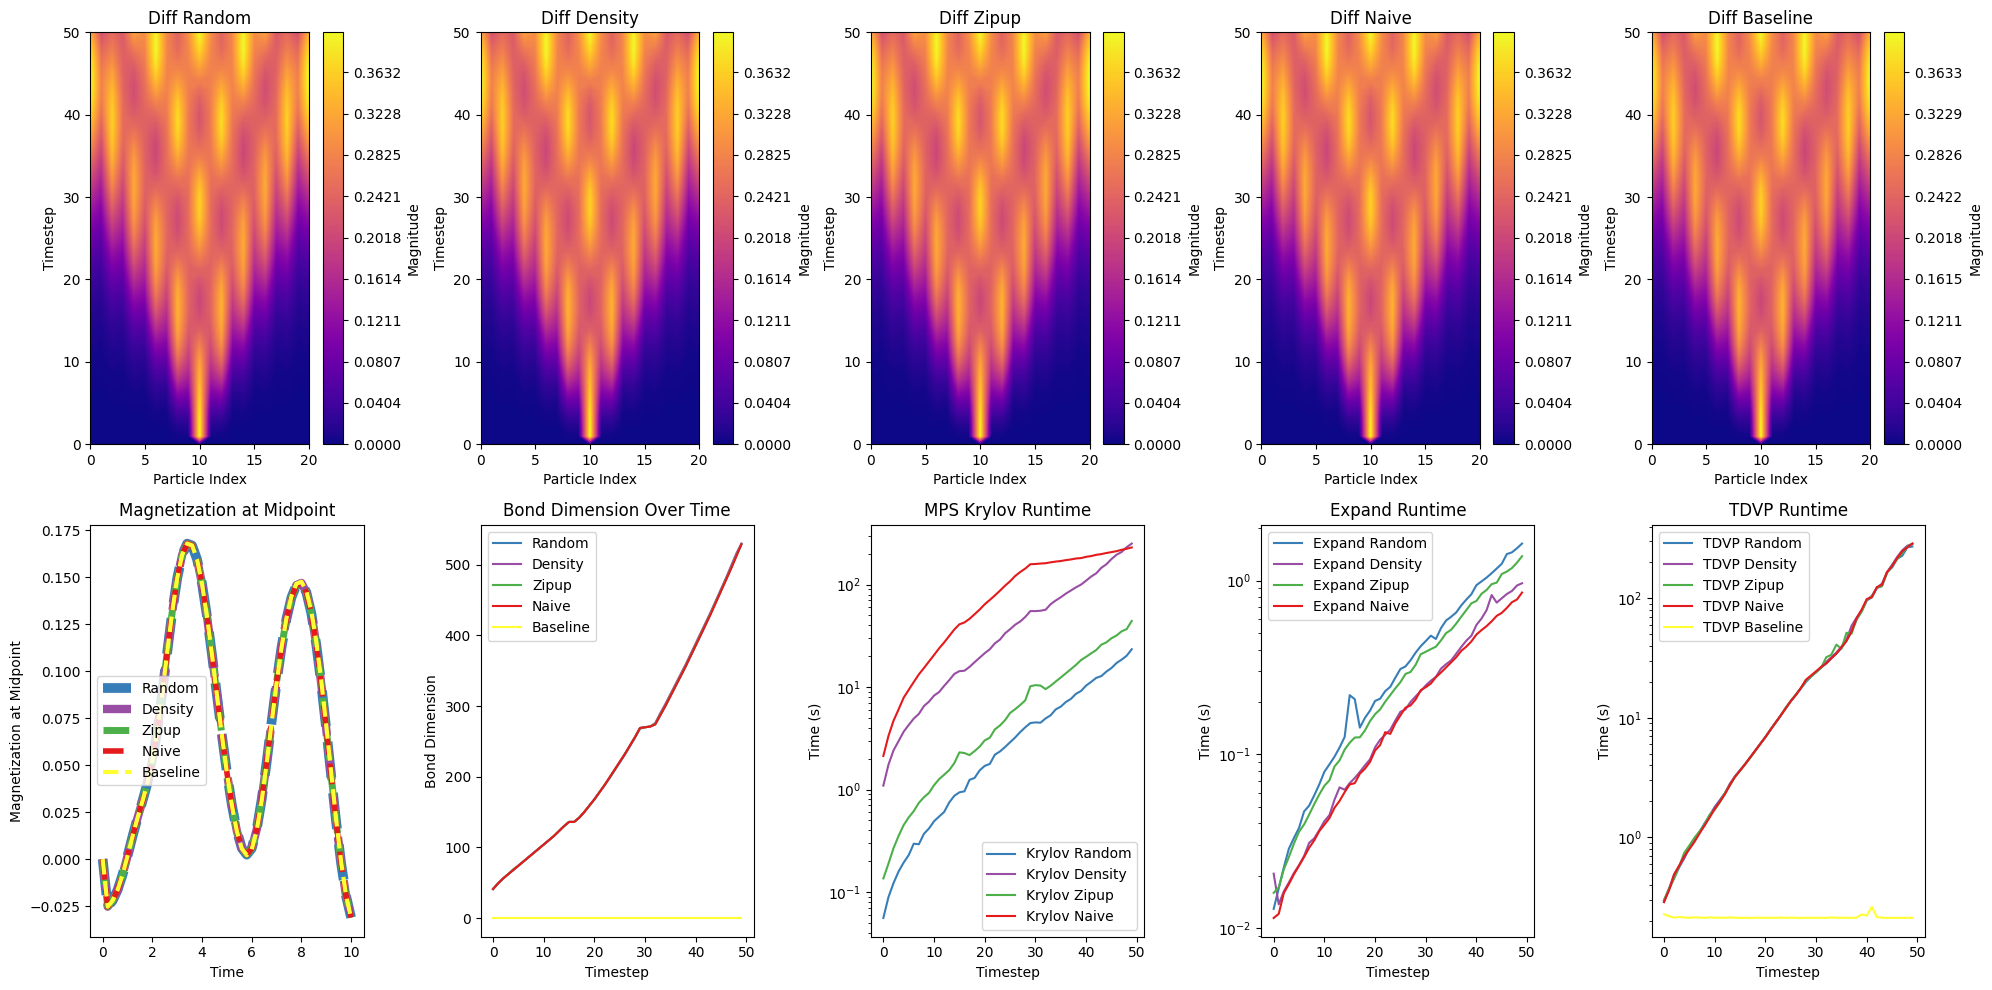

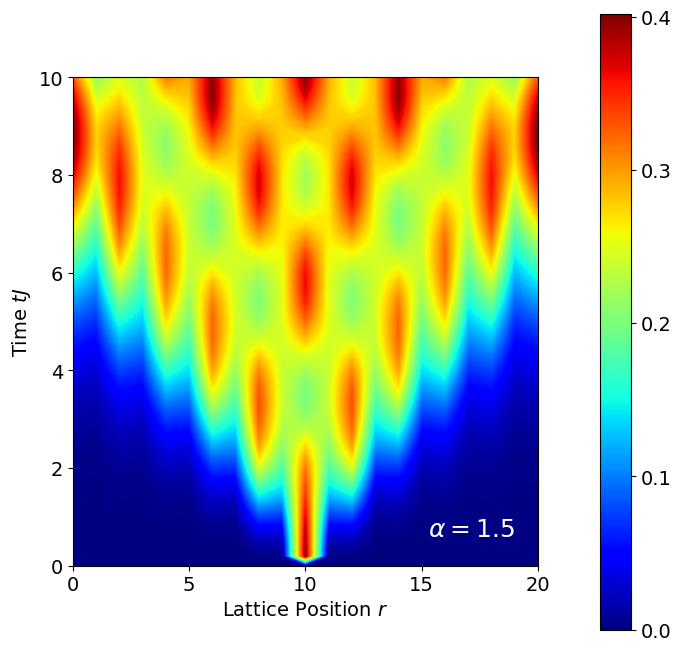

False
Maximum difference between random and naive: 2.1881931897352325e-06


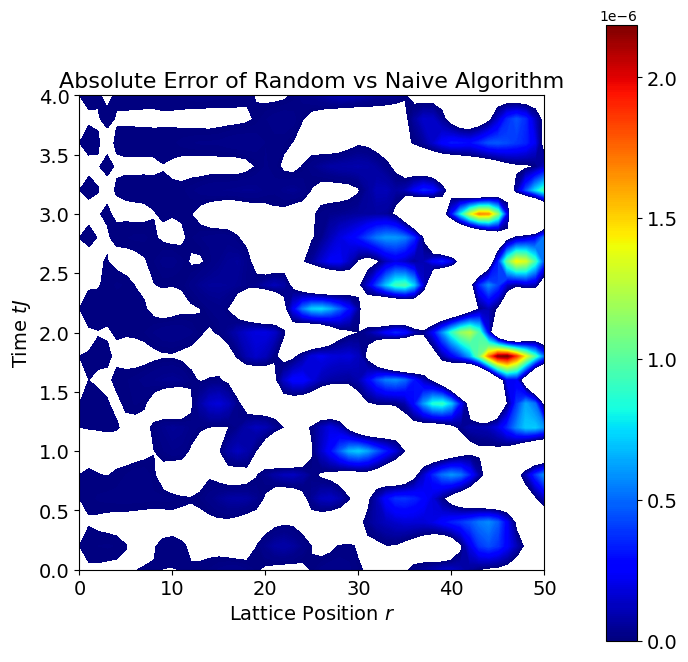

In [60]:
def MPS_krylov(mps, mpo, basis_size=3, stop=Cutoff(1e-14), contraction_type='random', sketchincrement=2, sketchdim=10, sweeps=1):
    basis = [mps]
    k_vec = mps
    if contraction_type == "naive":
        for t in range(basis_size - 1):
            k_vec = mps_mpo_blas(k_vec, mpo, stop=stop, round_type="dass_blas")
            k_vec.normalize()
            basis.append(k_vec)
            
    elif contraction_type == "random":
        for t in range(basis_size - 1):
            k_vec_1 = random_contraction_inc(mpo, k_vec, stop=stop, accuracychecks=False, 
                                            finalround=None, sketchincrement=sketchincrement, sketchdim=sketchdim)
            # k_vec_2 = mps_mpo_blas(k_vec, mpo, stop=FixedDimension(10), round_type="dass_blas")
            # print("Rand vs CTC", (k_vec_2 - k_vec_1).norm() / k_vec_2.norm())
            k_vec = k_vec_1
            k_vec.normalize()
            basis.append(k_vec)
                
    elif contraction_type == "fit":
        for t in range(basis_size - 1):
            k_vec_1 = fit(mpo, k_vec, max_sweeps=sweeps, stop=stop)
            # k_vec_2 = mps_mpo_blas(k_vec, mpo, stop=FixedDimension(10), round_type="dass_blas")
            # print("Fit vs CTC", (k_vec_2 - k_vec_1).norm() / k_vec_2.norm())
            k_vec = k_vec_1
            k_vec.normalize()
            basis.append(k_vec)
            
    elif contraction_type == "zipup":
        for t in range(basis_size - 1):
            k_vec_1 = zipup(mpo, k_vec,stop=stop,conditioning=True)
            # k_vec_2 = mps_mpo_blas(k_vec, mpo, stop=FixedDimension(10), round_type="dass_blas")
            # print("Fit vs CTC", (k_vec_2 - k_vec_1).norm() / k_vec_2.norm())
            k_vec = k_vec_1
            k_vec.normalize()
            basis.append(k_vec)
            
    elif contraction_type == "density":
        for t in range(basis_size - 1):
            k_vec = density_matrix(mpo, k_vec, stop=stop)
            k_vec.normalize()
            basis.append(k_vec)
    return basis

def write_results_to_csv(results, t, contraction_type, filename):
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)

    try:
        # Ensure t-1 is within valid range
        index = t - 1 if t > 0 else 0

        mags_modified = results['mags_modified'][contraction_type][:, index+1] if index+1 < results['mags_modified'][contraction_type].shape[1] else None
        mags_diff = results['mags_diff'][contraction_type][:, index+1] if index+1 < results['mags_diff'][contraction_type].shape[1] else None
        
        # Adjust index for timing data (t-1 because timing data is recorded for previous step)
        krylov_time = results['krylov_times'][contraction_type][index] if index < len(results['krylov_times'][contraction_type]) else float('nan')
        expand_time = results['expand_times'][contraction_type][index] if index < len(results['expand_times'][contraction_type]) else float('nan')
        tdvp_time = results['tdvp_times'][contraction_type][index] if index < len(results['tdvp_times'][contraction_type]) else float('nan')
        bond_dim = results['bond_dim'][contraction_type][index] if index < len(results['bond_dim'][contraction_type]) else float('nan')

        # Prepare data for the current step and contraction type
        data = {
            'Step': [t],
            'Contraction_Type': [contraction_type],
            'Mags_Modified': [','.join(map(str, mags_modified)) if mags_modified is not None else ''],
            'Mags_Diff': [','.join(map(str, mags_diff)) if mags_diff is not None else ''],
            'Krylov_Time': [krylov_time],
            'Expand_Time': [expand_time],
            'TDVP_Time': [tdvp_time],
            'Bond_Dim': [bond_dim]
        }
        df = pd.DataFrame(data)

        # Write the data to CSV
        df.to_csv(filename, mode='a', header=not os.path.isfile(filename), index=False)
    except Exception as e:
        print(f"Error writing to CSV: {e}")

def run_experiment_with_comparison(N, dt, steps, stop, alpha, contraction_types):
    results = {
        'mags_modified': {ct: np.zeros((N, steps + 1)) for ct in contraction_types + ['baseline']},
        'mags_diff': {ct: np.zeros((N, steps + 1)) for ct in contraction_types + ['baseline']},
        'krylov_times': {ct: [] for ct in contraction_types + ['baseline']},
        'expand_times': {ct: [] for ct in contraction_types + ['baseline']},
        'tdvp_times': {ct: [] for ct in contraction_types + ['baseline']},
        'bond_dim': {ct: [] for ct in contraction_types + ['baseline']}
    }
    results['mags_modified']['baseline'] = np.zeros((N, steps + 1))
    results['mags_diff']['baseline'] = np.zeros((N, steps + 1))
    results['krylov_times']['baseline'] = [0] * steps
    results['expand_times']['baseline'] = [0] * steps
    results['bond_dim']['baseline'] = [0] * steps
    


    mps = MPS.random_mps(N, 2)
    mpo = long_range_XY_model(N, alpha=alpha, stop=Cutoff(1e-8))
    # mpo = heisenberg(N)
    # mpo = long_range_tfim(N, h=1.33, stop=Cutoff(1e-8))

    mpo_for_krylov = mpo.copy()
    mpo_for_krylov.scale(-1j * dt)
    mpo_for_krylov = mpo_for_krylov.add(MPO.identity(2, N), compress=False)
    
    print("Running DMRG2...")
    groundstate, _ = dmrg2(mpo, mps, sweeps=2, stop=Cutoff(1e-8))
    groundstate.canonize_left()
    groundstate.canonize_right()
    
    groundstate.show()
    midpoint = N // 2
    mod_state = groundstate.copy()
    mod_state[midpoint] = np.einsum("XdY,dk->XkY", mod_state[midpoint], scipy.linalg.expm(1j * pauli_y * np.pi / 4))
    mags_groundstate = measure_magnetizations(groundstate, op=pauli_x)
    
    # stop = Cutoff(1e-14)
    # prod1=mps_mpo_blas(mod_state,mpo,stop=stop,round_type="dass_blas")
    # prod2= fit(mpo,mod_state,max_sweeps=10,stop=stop)
    # prod3= random_contraction_inc(mpo,mod_state, stop=stop, accuracychecks=False, 
    #                                         finalround=None, sketchincrement=3, sketchdim=2)
    # print((prod1-prod2).norm()/prod1.norm())
    # print((prod1-prod3).norm()/prod1.norm())
    
    filename = "Figure3_data/data.csv"  
    
    for contraction_type in contraction_types + ['baseline']:
        print()
        print()
        print(contraction_type)
        current_mps = mod_state.copy()
        current_mps.canonize_left_blas()
        
        for t in tqdm(range(steps)):
            if contraction_type != 'baseline':
                #=================Krylov=================
                start_time = time.time()
                random_basis_enhancement = MPS_krylov(current_mps, mpo_for_krylov, basis_size=3, stop=FixedDimension(current_mps.max_bond_dim()), 
                                                      contraction_type=contraction_type, sweeps=2)
                results['krylov_times'][contraction_type].append(time.time() - start_time)
                #=================Basis Enrichment=================
                start_time = time.time()
                current_mps_after = expand(random_basis_enhancement, cutoff=1e-3)
                current_mps = current_mps_after
                results['expand_times'][contraction_type].append(time.time() - start_time)
                results['bond_dim'][contraction_type].append(current_mps.max_bond_dim())
                
            #=================TDVP=================
            start_time = time.time()
            current_mps, _, _ = tdvp_implicit(current_mps, mpo, dt, sweeps=1, krylov_depth=5, use_lanczos=True)
            results['tdvp_times'][contraction_type].append(time.time() - start_time)
            
            #=================Measure=================
            if contraction_type == "naive" or "random":
                results['mags_modified'][contraction_type][:, t + 1] = measure_magnetizations(current_mps, op=pauli_x)
                results['mags_diff'][contraction_type][:, t + 1] = results['mags_modified'][contraction_type][:, t + 1] - mags_groundstate
                
            #dass_round_blas(current_mps, stop=Cutoff(1e-8))
            write_results_to_csv(results, t, contraction_type, filename)
    
    return results, N, dt, steps, contraction_types
        
N = 21
dt = 0.2
alpha = 1.5
steps = 50
np.random.seed(42)
stop = Cutoff(1e-4)
contraction_types = ['random','density','zipup','naive']  

results, N, dt, steps, contraction_types = run_experiment_with_comparison(N, dt, steps, stop, alpha, contraction_types)
plot_results(results, N, dt, steps, contraction_types)
plot_figure(results,N,dt)

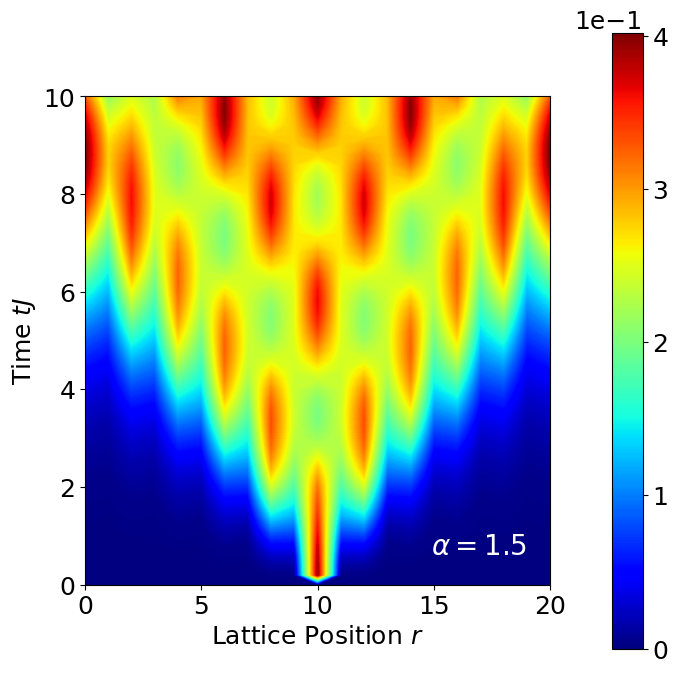

False
(21, 51) (21, 51)
Maximum difference between random and naive: 2.1881931897352325e-06


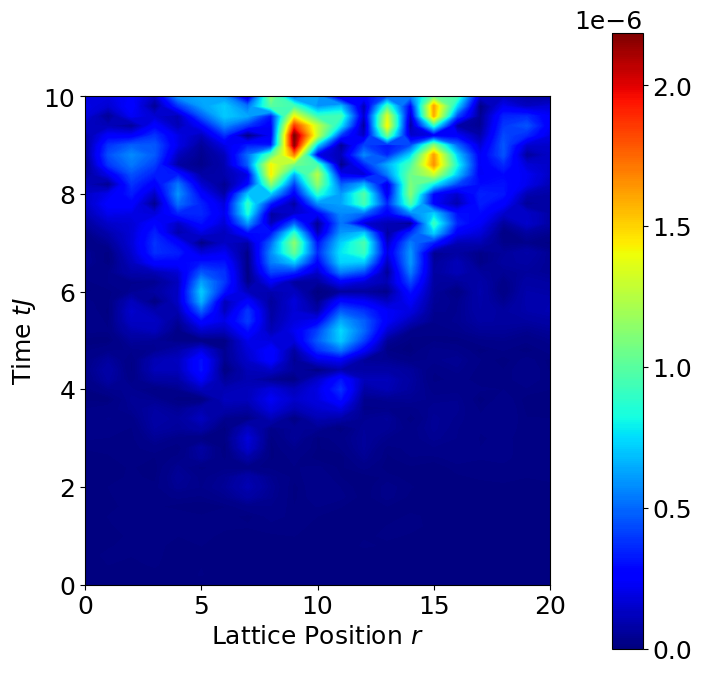

In [82]:
def plot_figure(results, N, dt):
    palette = sns.color_palette("Set1", 6)
    plot_colors = {
        'naive': palette[0],
        'random': palette[1],
        'zipup': palette[2],
        'density': palette[3],
        'fit': palette[4],
        'baseline': palette[5],
    }
    # Subroutine to create contour plot
    def plot_magnetization(matrix, xlabel, ylabel, title, text_annotation, dt):
        rows, cols = matrix.shape
        fig, ax = plt.subplots(figsize=(8, 8))  # Adjust aspect ratio based on matrix shape

        # Create contour plot
        levels = np.linspace(0, np.max(matrix), 300)
        contour = ax.contourf(np.array(range(cols)), np.linspace(0,(rows-1)*dt,rows), matrix, levels=levels, cmap='jet', vmin=0)

        # Create an axis for the colorbar with the same height as the plot
        cbar = fig.colorbar(contour, ax=ax, location='right', pad=0.1)

        # Reduce the number of ticks on the color bar
        cbar.locator = ticker.MaxNLocator(nbins=5)
        cbar.update_ticks()
        cbar.formatter.set_powerlimits((0, 0))  # Force scientific notation if needed
        cbar.update_ticks()
        cbar.ax.yaxis.offsetText.set(size=18)
        # Set font size for color bar tick labels
        cbar.ax.tick_params(labelsize=18)

        # Set font size for plot tick labels
        ax.tick_params(axis='both', which='major', labelsize=18)

        # Set labels
        ax.set_xlabel(xlabel, fontsize=18)
        ax.set_ylabel(ylabel, fontsize=18)

        # Add text annotation in the plot if provided
        if text_annotation:
            ax.text(0.95, 0.05, text_annotation, color='white', fontsize=20,
                    horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

        # Set the aspect ratio manually based on the matrix shape
        ax.set_aspect(cols / ((rows-1)*dt))

        # Set the title for the plot if provided
        if title:
            plt.title(title, fontsize=18)

        # Show plot
        plt.show()


    random_magnetizations = np.abs(results['mags_diff']['random'].T)
    plot_magnetization(random_magnetizations, 
                    xlabel='Lattice Position $r$', 
                    ylabel='Time $tJ$', 
                    title=None, 
                    text_annotation=r'$\alpha = 1.5$', 
                    dt=dt)
    
    random_magnetizations = results['mags_modified']['random']
    naive_magnetizations = results['mags_modified']['naive']
    print(np.allclose(random_magnetizations,naive_magnetizations))
    diff = np.abs(random_magnetizations - naive_magnetizations)
    max_diff = np.max(diff)
    print(random_magnetizations.shape,naive_magnetizations.shape)
    print(f"Maximum difference between random and naive: {max_diff}")
    relative_error = np.abs(random_magnetizations.T - naive_magnetizations.T)+1e-16
    # naive_magnetizations #TODO: try abs here 

    plot_magnetization(relative_error, 
                    xlabel='Lattice Position $r$', 
                    title=None,
                    ylabel='Time $tJ$', 
                    text_annotation=None, 
                    dt=dt)
    
plot_figure(results,N,dt)

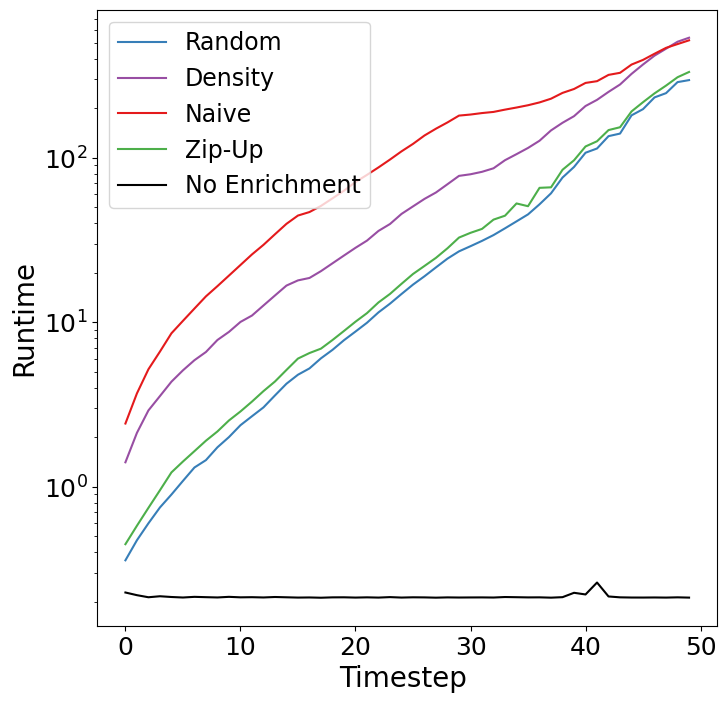

In [89]:
total_times = total_runtime(results)

palette = sns.color_palette("Set1", 6)
plot_colors = {
    'naive': palette[0],   # First color from the palette
    'random': palette[1],  # Second color from the palette
    'zipup': palette[2],   # Third color from the palette
    'density': palette[3], # Fourth color from the palette
    'fit': palette[4],     # Fifth color from the palette
    'rand_then_orth': 'g', # Green for 'rand_then_orth'
    'nyst': 'b',           # Blue for 'nyst'
}
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust aspect ratio based on matrix shape

for ct, times in total_times.items():
    color = plot_colors.get(ct, 'k')  # 'k' is a default color (black) in case `ct` is not in `plot_colors`
    if ct == "baseline":
        plt.plot(times, label='No Enrichment', color=color)
    elif ct == "zipup":
        plt.plot(times, label='Zip-Up', color=color)
    else:
        plt.plot(times, label=f'{ct.capitalize()}', color=color)
plt.tick_params(axis='both', which='major', labelsize=18)
    
plt.xlabel('Timestep ',fontsize=20)
plt.ylabel('Runtime', fontsize=20)
plt.legend( fontsize=17)
plt.yscale('log')
# plt.title('Total Runtime for Different Contraction Types')
plt.show()
# plot_results_separately(results, N, dt, steps, contraction_types)


In [1]:
import numpy as np
import csv

# Initialize the dictionary structure as per your code
N = 11  # Assuming 50 as per your example
steps = 25  # Assuming the same number of steps
contraction_types = ['random','zipup','density','naive']  # Add the actual types
dt = 0.02  # Example time step, adjust as necessary

# Structure to hold the results
results = {
    'mags_modified': {ct: np.zeros((N, steps + 1)) for ct in contraction_types + ['baseline']},
    'mags_diff': {ct: np.zeros((N, steps + 1)) for ct in contraction_types + ['baseline']},
    'krylov_times': {ct: [] for ct in contraction_types + ['baseline']},
    'expand_times': {ct: [] for ct in contraction_types + ['baseline']},
    'tdvp_times': {ct: [] for ct in contraction_types + ['baseline']},
    'bond_dim': {ct: [] for ct in contraction_types + ['baseline']}
}

# Path to your file
file_path = 'Figure3_data/recovered_data.csv'

# Read the CSV and fill the results dictionary
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    # next(reader)  # Skip the header if present
    for row in reader:
        # Assume the structure of each row matches your example
        t = int(row[0])
        contraction_type = row[1]  # Assuming this column is in the file
        mags_modified = np.array(list(map(float, row[2].split(','))))
        mags_diff = np.array(list(map(float, row[3].split(','))))
        krylov_time = float(row[4])
        expand_time = float(row[5])
        tdvp_time = float(row[6])
        bond_dim = int(row[7])

        # Populate the results dictionary
        results['mags_modified'][contraction_type][:, t] = mags_modified
        results['mags_diff'][contraction_type][:, t] = mags_diff
        results['krylov_times'][contraction_type].append(krylov_time)
        results['expand_times'][contraction_type].append(expand_time)
        results['tdvp_times'][contraction_type].append(tdvp_time)
        results['bond_dim'][contraction_type].append(bond_dim)

# The results dictionary is now populated with data from the CSV
print("Data successfully recovered from the CSV file.")
print(results)
plot_results_separately(results, N, dt, steps, contraction_types)

ValueError: could not broadcast input array from shape (21,) into shape (11,)

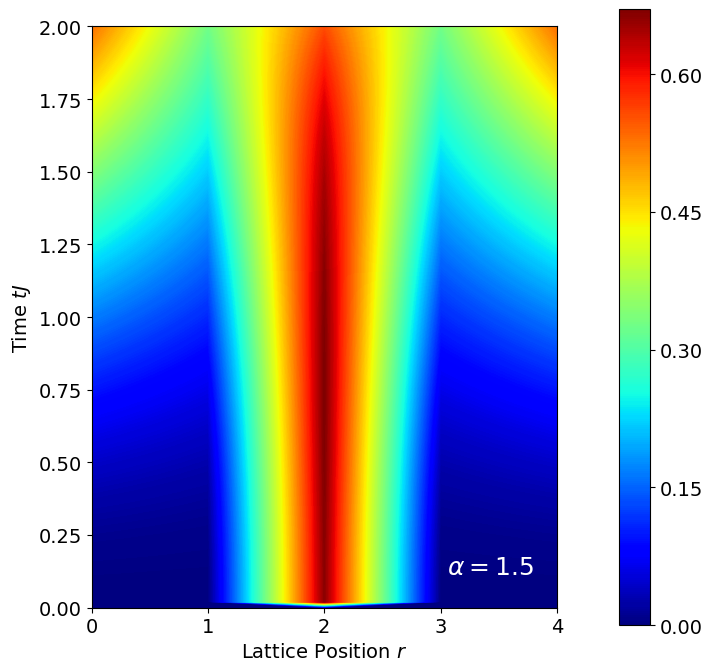

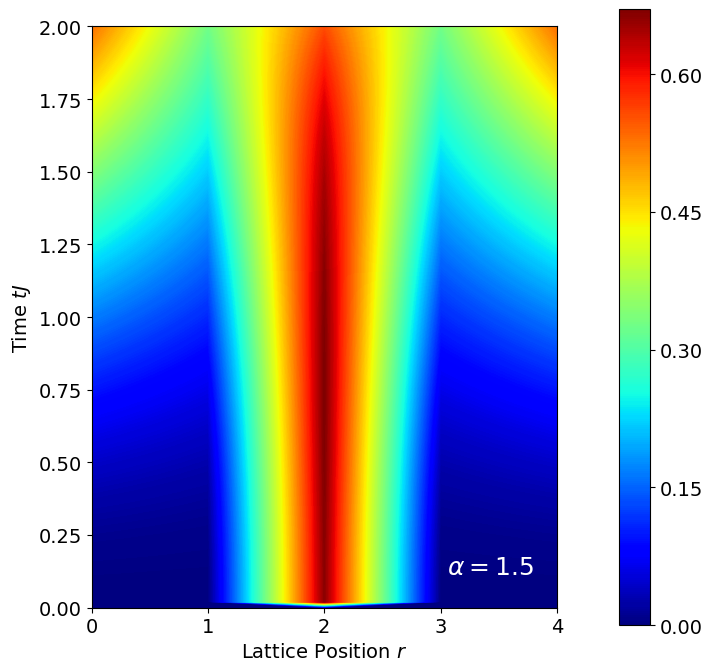

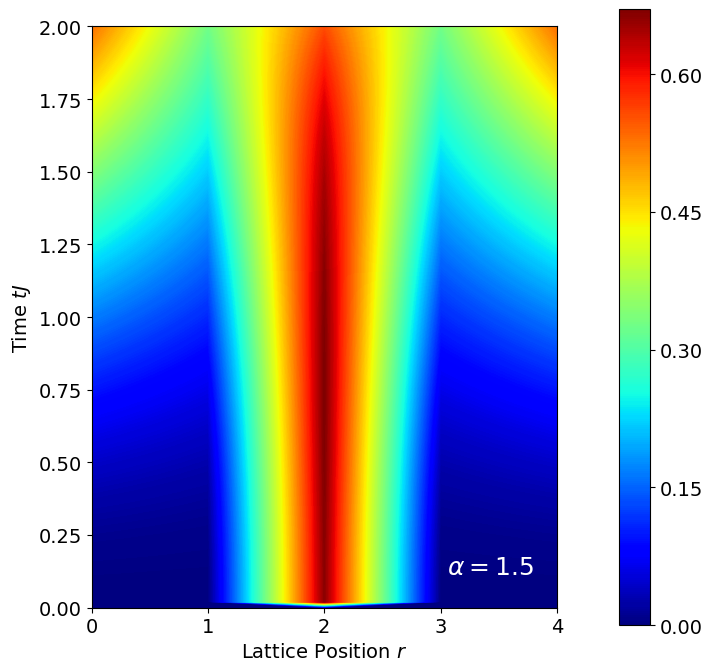

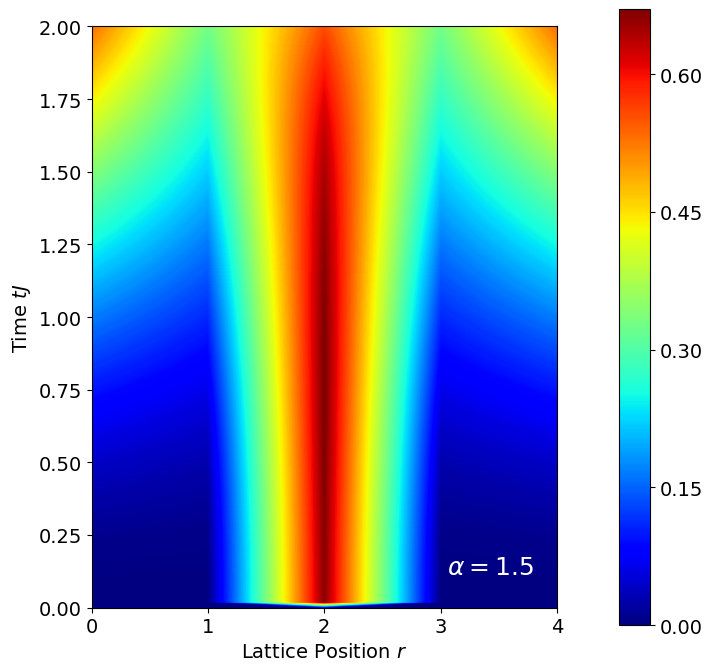

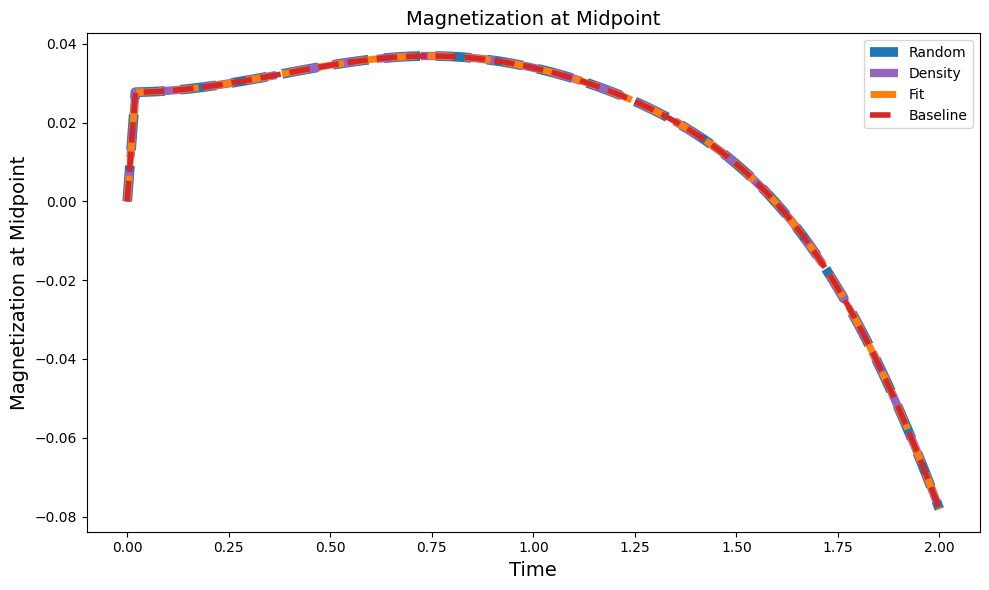

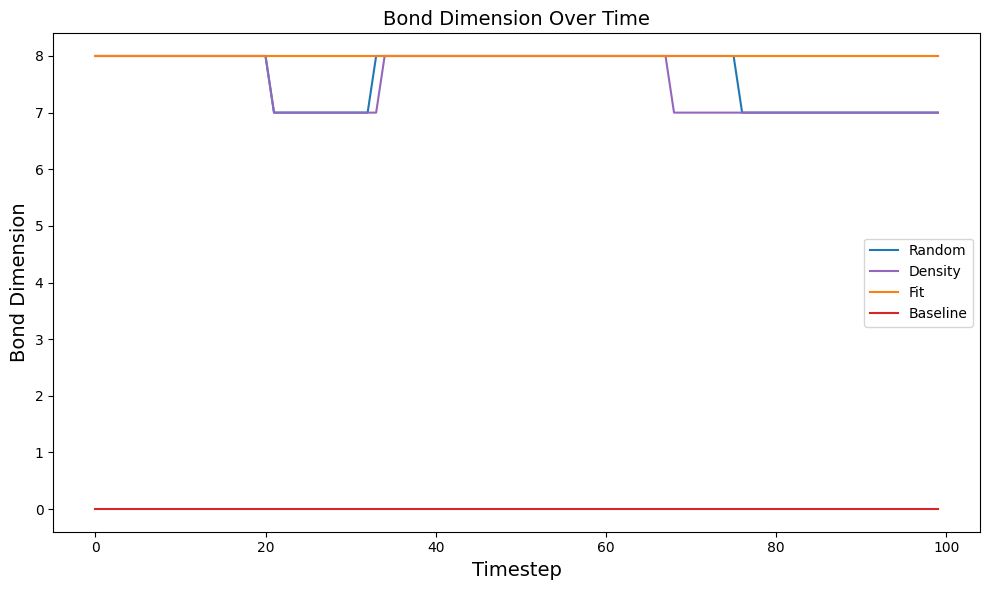

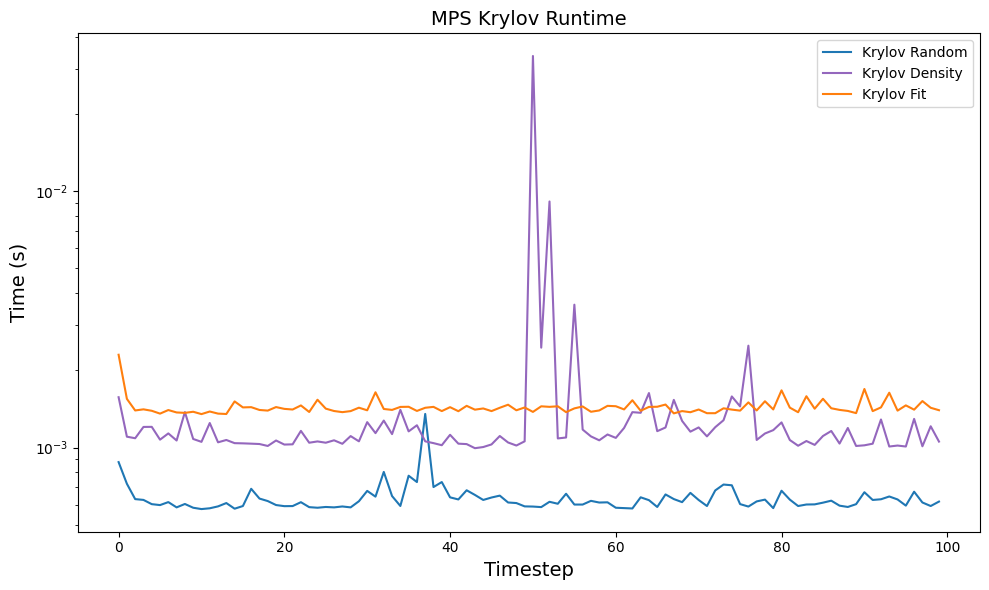

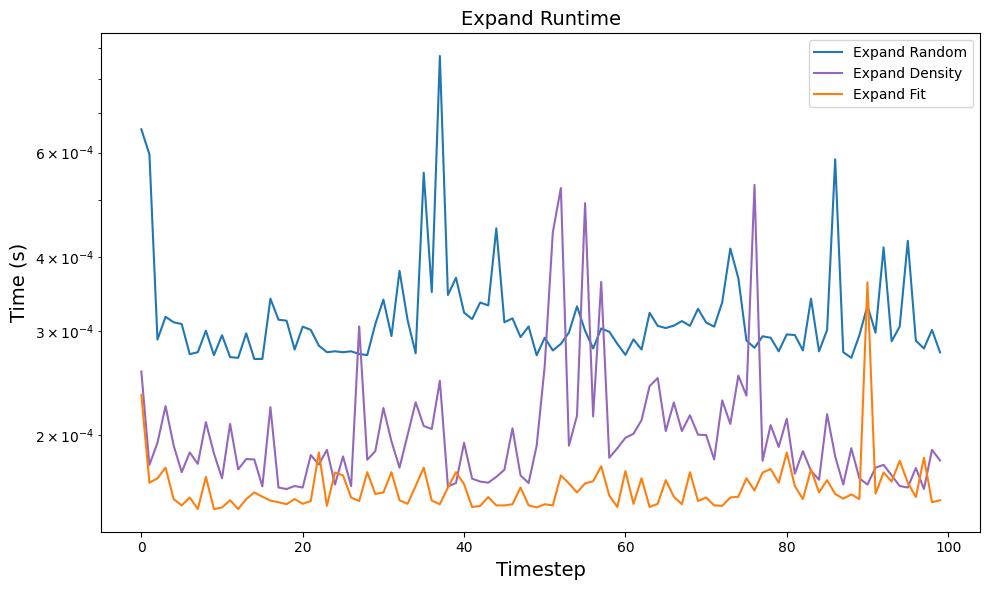

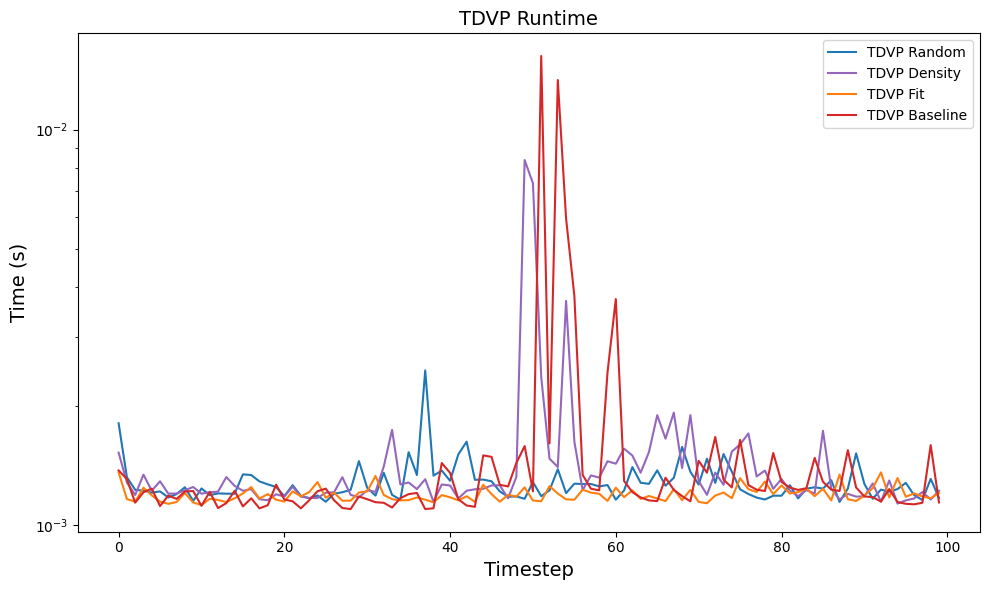

In [113]:
plot_results_separately(results, N, dt, steps, contraction_types)

N=101 
```
for random + density 
Running DMRG2...
100%|██████████| 397/397 [00:44<00:00,  8.92it/s] 
100%|██████████| 35/35 [59:30<00:00, 102.02s/it]
 94%|█████████▍| 33/35 [4:12:01<38:31, 1155.86s/it] 
 ```
```
for fit
Running DMRG2...
100%|██████████| 397/397 [00:43<00:00,  9.14it/s] 
 51%|█████▏    | 18/35 [4:26:58<4:12:09, 1789.94s/it] 
```

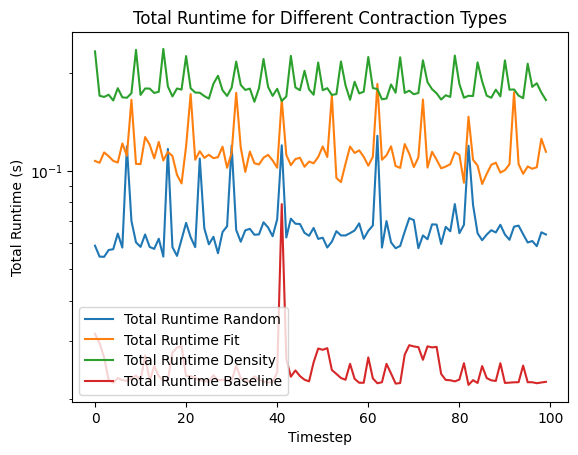

In [24]:
def total_runtime(results):
    total_times = {
        'random': [],
        'fit': [],
        'density':[],
        #'naive': [],
        'baseline': []
    }

    contraction_types = list(total_times.keys())

    for ct in contraction_types:
        total_runtime_for_ct = []
        
        for t in range(len(results['tdvp_times'][ct])):
            krylov_time = results['krylov_times'][ct][t] if ct != 'baseline' else 0
            expand_time = results['expand_times'][ct][t] if ct != 'baseline' else 0
            tdvp_time = results['tdvp_times'][ct][t]
            
            total_time = krylov_time + expand_time + tdvp_time
            
            total_runtime_for_ct.append(total_time)
        
        total_times[ct] = total_runtime_for_ct
    
    return total_times
total_times = total_runtime(results)

for ct, times in total_times.items():
    plt.plot(times, label=f'Total Runtime {ct.capitalize()}')
plt.xlabel('Timestep')
plt.ylabel('Total Runtime (s)')
plt.legend()
plt.yscale('log')
plt.title('Total Runtime for Different Contraction Types')
plt.show()

In [7]:
def read_results_from_csv(filename):
    try:
        results = {}
        
        # Open the CSV file
        with open(filename, 'r') as file:
            reader = csv.reader(file)
            
            for row in reader:
                # Check if row is empty
                if not row or len(row) < 8:
                    continue
                
                # Extract fields from row
                step = int(row[0])
                contraction_type = row[1]
                mags_modified = list(map(float, row[2].strip('"').split(',')))
                mags_diff = list(map(float, row[3].strip('"').split(',')))
                krylov_time = float(row[4])
                expand_time = float(row[5])
                tdvp_time = float(row[6])
                bond_dim = float(row[7])
                
                # Ensure contraction_type is in the dictionary
                if contraction_type not in results:
                    results[contraction_type] = {
                        'steps': [],
                        'mags_modified': [],
                        'mags_diff': [],
                        'krylov_times': [],
                        'expand_times': [],
                        'tdvp_times': [],
                        'bond_dim': []
                    }
                
                # Append data to the corresponding lists
                results[contraction_type]['steps'].append(step)
                results[contraction_type]['mags_modified'].append(mags_modified)
                results[contraction_type]['mags_diff'].append(mags_diff)
                results[contraction_type]['krylov_times'].append(krylov_time)
                results[contraction_type]['expand_times'].append(expand_time)
                results[contraction_type]['tdvp_times'].append(tdvp_time)
                results[contraction_type]['bond_dim'].append(bond_dim)
        
        return results
    
    except FileNotFoundError:
        raise FileNotFoundError(f"The file {filename} does not exist.")
    except Exception as e:
        raise Exception(f"An unexpected error occurred: {e}")

Contraction Type: random
An unexpected error occurred: 'list' object has no attribute 'shape'
Contraction types: ['random']


/var/folders/6k/g8w9pg6j4b3b_76hhg422g440000gn/T/ipykernel_41530/3590868116.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 0].legend()


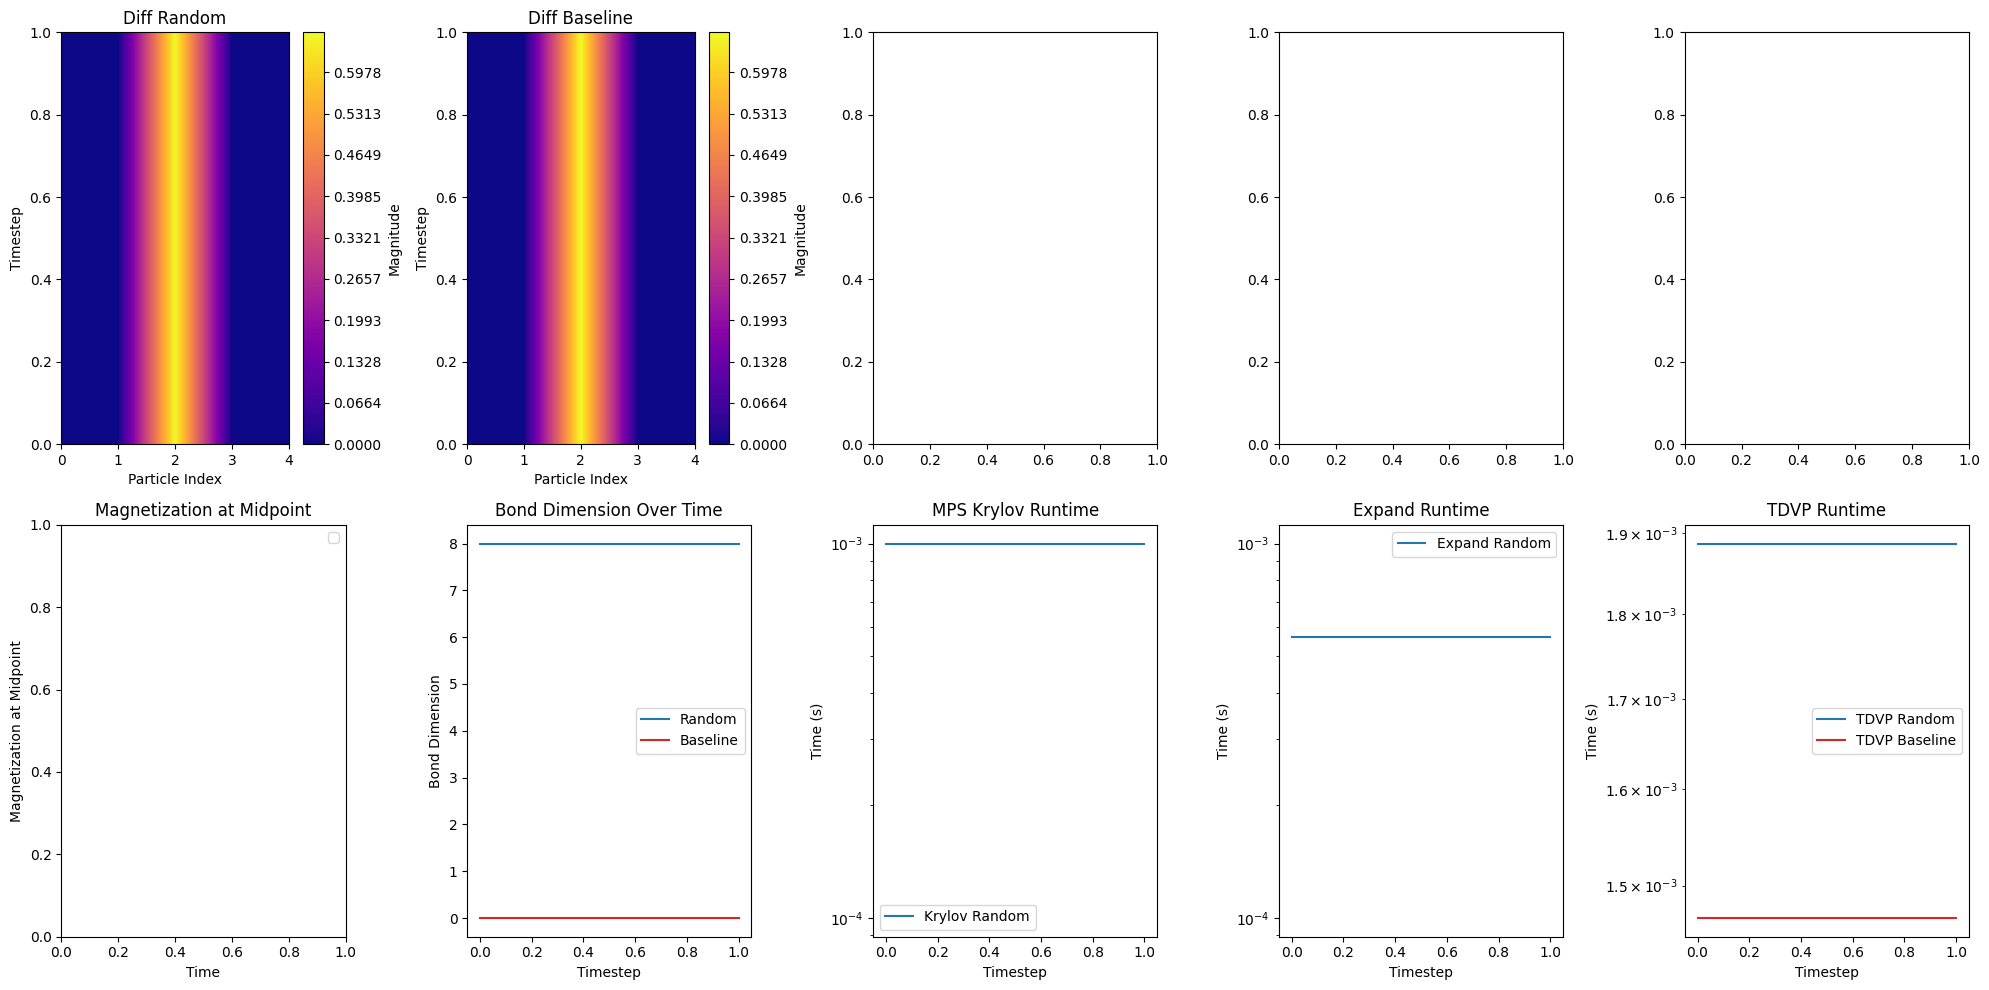

In [8]:
filename = '/Users/pren/Research/RandomMPOMPS/Figures/Figure3_data/data.csv'
try:
    recovered_data = read_results_from_csv(filename)
    
    # Print the results for each contraction type
    for contraction_type, data in recovered_data.items():
        print(f"Contraction Type: {contraction_type}")
        print("Mags Modified shape:", data['mags_modified'].shape)
        print("Mags Diff shape:", data['mags_diff'].shape)
        print("Krylov Times:", data['krylov_times'])
        print("Expand Times:", data['expand_times'])
        print("TDVP Times:", data['tdvp_times'])
        print("Bond Dimensions:", data['bond_dim'])
        print("\n")

except FileNotFoundError as e:
    print(e)
except ValueError as e:
    print(e)
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    

def plot_results2(results, N, dt, steps, contraction_types):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # Adjusted for 5 columns
    colors = {
        'random': '#1f77b4',  # Blue
        'fit': '#ff7f0e',     # Orange
        'naive': '#2ca02c',   # Green
        'baseline': '#d62728', # Red
        'density': '#9467bd' # Purple
    }
    
    # Debug: Check the number of contraction types
    print(f"Contraction types: {contraction_types}")
    
    # First Row: Magnetization Differences Contour Plots
    for i, ct in enumerate(contraction_types + ['baseline']):
        ax = axs[0, i]
        mags_diff_df = np.array(results[ct]['mags_diff'])
        # Debug: Check dimensions of mags_diff_df
        levels = np.linspace(0, np.abs(mags_diff_df).max(), 300)
        contour = ax.contourf(np.abs(mags_diff_df), levels=levels, cmap='plasma', vmin=0)
        cbar = fig.colorbar(contour, ax=ax)
        cbar.set_label('Magnitude')
        ax.set_title(f'Diff {ct.capitalize()}')
        ax.set_xlabel('Particle Index')
        ax.set_ylabel('Timestep')
    
    # Second Row
    # Magnetization at Midpoint
    for ct in contraction_types + ['baseline']:
        mags_modified_df = np.array(results[ct]['mags_modified'])
        # Debug: Check dimensions of mags_modified_df
        if mags_modified_df.shape[0] <= N // 2:
            print(f"Warning: Index {N // 2} out of bounds for mags_modified_df with shape {mags_modified_df.shape}")
            continue
        ax = axs[1, 0]
        ax.plot(np.linspace(0, dt * steps, steps + 1), mags_modified_df[N // 2], label=ct.capitalize(), color=colors[ct])
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Magnetization at Midpoint')
    axs[1, 0].legend()
    axs[1, 0].set_title('Magnetization at Midpoint')

    # Bond Dimension Over Time
    for ct in contraction_types + ['baseline']:
        ax = axs[1, 1]
        ax.plot(results[ct]['steps'], results[ct]['bond_dim'], label=ct.capitalize(), color=colors[ct])
    axs[1, 1].set_xlabel('Timestep')
    axs[1, 1].set_ylabel('Bond Dimension')
    axs[1, 1].legend()
    axs[1, 1].set_title('Bond Dimension Over Time')

    # MPS Krylov Runtimes
    for ct in contraction_types:
        ax = axs[1, 2]
        ax.plot(results[ct]['steps'], results[ct]['krylov_times'], label=f'Krylov {ct.capitalize()}', color=colors[ct])
    axs[1, 2].set_xlabel('Timestep')
    axs[1, 2].set_ylabel('Time (s)')
    axs[1, 2].set_yscale('log')
    axs[1, 2].legend()
    axs[1, 2].set_title('MPS Krylov Runtime')

    # Expand Runtimes
    for ct in contraction_types:
        ax = axs[1, 3]
        ax.plot(results[ct]['steps'], results[ct]['expand_times'], label=f'Expand {ct.capitalize()}', color=colors[ct])
    axs[1, 3].set_xlabel('Timestep')
    axs[1, 3].set_ylabel('Time (s)')
    axs[1, 3].set_yscale('log')
    axs[1, 3].legend()
    axs[1, 3].set_title('Expand Runtime')

    # TDVP Runtimes
    for ct in contraction_types + ['baseline']:
        ax = axs[1, 4]
        ax.plot(results[ct]['steps'], results[ct]['tdvp_times'], label=f'TDVP {ct.capitalize()}', color=colors[ct])
    axs[1, 4].set_xlabel('Timestep')
    axs[1, 4].set_ylabel('Time (s)')
    axs[1, 4].set_yscale('log')
    axs[1, 4].legend()
    axs[1, 4].set_title('TDVP Runtime')

    plt.tight_layout()
    plt.show()
plot_results2(recovered_data,N,dt,steps,contraction_types)